# Complex Architectures

Here we develop implementations of transformers for CDR3 sequences.

Resources:
- https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from NegativeClassOptimization import ml
from NegativeClassOptimization import utils
import NegativeClassOptimization.preprocessing as preprocessing

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
sn10 = ml.SN10()
print(f"Number of trainable parameters in SN10: {utils.num_trainable_params(sn10)}")

Number of trainable parameters in SN10: 2221


In [3]:
transformer = ml.Transformer(
    vocab_size=20, 
    d_model=12,  # 20?
    nhead=2,
    dim_feedforward=10,
    num_layers=2,
    dropout=0.1,
    activation="relu",
    classifier_dropout=0.1,
    )

utils.num_trainable_params(transformer)

# transformer = torch.nn.Transformer(
#     d_model=20,
#     nhead=2,
#     num_encoder_layers=2,
#     num_decoder_layers=2,
#     dim_feedforward=16,
#     dropout=0.1,
#     activation="relu",
# )

# src = torch.rand(32, 1, 20)  # S, N, E
# tgt = torch.rand(17, 1, 20)  # T, N, E
# transformer(src, tgt).shape

# utils.num_trainable_params(transformer)

2121

In [4]:
# Does not support batched input
# N_seqs, N_chars

# 1 sequence
transformer(torch.rand(1, 13).round().type(torch.long))

# 2 sequences
# transformer(torch.rand(2, 13).round().type(torch.long))

# Testing indexes of vocabulary
# transformer(torch.tensor(np.array([0])))
# transformer(torch.tensor(np.array([19])))
# transformer(torch.tensor(np.array([20])))  # error expected, out of vocabulary index range

tensor([[0.4269]], grad_fn=<SigmoidBackward0>)

In [5]:
cnn = ml.CNN()
utils.num_trainable_params(cnn), cnn.forward(torch.rand(1, 1, 11, 20))

(299, tensor([[0.4508]], grad_fn=<SigmoidBackward0>))

## Predict from one CDR3 / CDR3 batch for each model

In [6]:
df = utils.load_global_dataframe()

ag_pos = "3VRL"
ag_neg = "1ADQ"
df = df.loc[df["Antigen"].isin([ag_pos, ag_neg])].copy()
df = df.drop_duplicates(["Slide"])

N = 1000
df = df.sample(n=N, random_state=42)
df = df.sample(frac=1, random_state=42)

df.head(2)

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID,Antigen
35067,1123588_03a,CAKTLFYDGYYRYFDVW,True,TLFYDGYYRYF,-96.00,128933-BRRSLUDUUS,1ADQ_1123588_03a,1ADQ
32364,4368719_02a,CARWDYGSLLFAYW,True,RWDYGSLLFAY,-96.54,137191-BRDSDLSRRU,1ADQ_4368719_02a,1ADQ


In [8]:
train_data, test_data, train_loader, test_loader = preprocessing.preprocess_data_for_pytorch_binary(
    df_train_val=df.iloc[:int(N*0.8)],
    df_test_closed=df.iloc[int(N*0.8):],
    ag_pos=[ag_pos],
    batch_size=32,
    scale_onehot=False,
)

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


In [9]:
X = train_data[0][0]

Forward loop for 1 sequence for each model.

In [10]:
sn10.forward(X)

# We reshape to matrix (11 x 20) then convert to indexes (11,) and then reshape to (1 x 11)
X_tr = X.reshape(11, 20).argmax(axis=1).reshape(1, 11)
transformer.forward(X_tr)

X_cnn = X.reshape(1, 1, 11, 20)
cnn.forward(X_cnn)

tensor([[0.4496]], grad_fn=<SigmoidBackward0>)

Forward loop for batch of sequences for each model.

In [11]:
X_batch = ml.Xy_from_loader(train_loader)[0]

sn10.forward(X_batch)

X_tr = X_batch.reshape(-1, 11, 20).argmax(axis=2).reshape(-1, 11)
transformer.forward(X_tr)

X_cnn = X_batch.reshape(-1, 1, 11, 20)
cnn.forward(X_cnn);

## Train each model

SN10

In [12]:
model = sn10.to("cpu")

learning_rate = 0.01
epochs = 5
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ml.train_loop(train_loader, model, loss_fn, optimizer)
    ml.test_loop(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 0.670021  [    0/  800]
Test Error: 
 Acc: 54.0 Avg loss: 0.681943 

Epoch 2
-------------------------------
loss: 0.670141  [    0/  800]


/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Acc: 54.0 Avg loss: 0.675175 

Epoch 3
-------------------------------
loss: 0.687221  [    0/  800]
Test Error: 
 Acc: 54.5 Avg loss: 0.672593 

Epoch 4
-------------------------------
loss: 0.676898  [    0/  800]
Test Error: 
 Acc: 57.5 Avg loss: 0.672621 

Epoch 5
-------------------------------
loss: 0.677199  [    0/  800]
Test Error: 
 Acc: 63.5 Avg loss: 0.672479 



Transformer

In [13]:
model = transformer.to("cpu")

learning_rate = 0.01
epochs = 5
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ml.train_loop(train_loader, model, loss_fn, optimizer)
    ml.test_loop(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 0.650435  [    0/  800]
Test Error: 
 Acc: 58.0 Avg loss: 0.681308 

Epoch 2
-------------------------------
loss: 0.741488  [    0/  800]
Test Error: 
 Acc: 53.0 Avg loss: 0.690868 

Epoch 3
-------------------------------
loss: 0.726630  [    0/  800]
Test Error: 
 Acc: 49.5 Avg loss: 0.691561 

Epoch 4
-------------------------------
loss: 0.675795  [    0/  800]
Test Error: 
 Acc: 51.5 Avg loss: 0.688478 

Epoch 5
-------------------------------
loss: 0.699254  [    0/  800]
Test Error: 
 Acc: 50.5 Avg loss: 0.698952 



CNN

In [14]:
model = cnn.to("cpu")

learning_rate = 0.01
epochs = 5
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ml.train_loop(train_loader, model, loss_fn, optimizer)
    ml.test_loop(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 0.673136  [    0/  800]
Test Error: 
 Acc: 54.0 Avg loss: 0.690879 

Epoch 2
-------------------------------
loss: 0.702368  [    0/  800]


/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Acc: 54.0 Avg loss: 0.688523 

Epoch 3
-------------------------------
loss: 0.701189  [    0/  800]
Test Error: 
 Acc: 54.0 Avg loss: 0.688876 

Epoch 4
-------------------------------
loss: 0.717253  [    0/  800]


/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Error: 
 Acc: 54.0 Avg loss: 0.687481 

Epoch 5
-------------------------------
loss: 0.717430  [    0/  800]
Test Error: 
 Acc: 54.0 Avg loss: 0.687981 



/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Evaluate comparatively performance in a binary case

In the previous section we've seen how to train each model type. Here we will code an evaluation of how they perform on a full dataset. If deemed to computationally demanding, this section will be scripted separately (and referenced here).

Models:
- SN10 (2.2k params)
- CNN (2.2k params)
- Transformer (2.2k params)
- SN10_enh (10k params)
- CNN_enh (10k params)
- Transformer_enh (10k params)

In [32]:
sn10 = ml.SN10()
cnn = ml.CNN(
    conv1_num_filters=16,
    conv1_filter_size=3,
    conv2_num_filters=12,
    conv2_filter_size=3,
    )
transformer = ml.Transformer(
    vocab_size=20, 
    d_model=12,
    nhead=2,
    dim_feedforward=10,
    num_layers=2,
    dropout=0.1,
    activation="relu",
    classifier_dropout=0.1,
    )

transformer_alt = ml.Transformer(
    vocab_size=20, 
    d_model=8,
    nhead=2,
    dim_feedforward=42,
    num_layers=2,
    dropout=0.1,
    activation="relu",
    classifier_dropout=0.1,
    )


sn10_enh = ml.SNN(num_hidden_units=48)
cnn_enh = ml.CNN(
    conv1_num_filters=32,
    conv1_filter_size=3,
    conv2_num_filters=32,
    conv2_filter_size=3,
    )
transformer_enh = ml.Transformer(
    vocab_size=20, 
    d_model=18,
    nhead=3,
    dim_feedforward=30,
    num_layers=4,
    dropout=0.1,
    activation="relu",
    classifier_dropout=0.1,
    )

model_names = [
    "sn10", 
    # "cnn", 
    "transformer", 
    "transformer_alt",
    # "sn10_enh", 
    # "cnn_enh", 
    # "transformer_enh"
    ]
models = [
    sn10, 
    # cnn, 
    transformer, 
    transformer_alt,
    # sn10_enh,
    # cnn_enh, 
    # transformer_enh
    ]
list(map(utils.num_trainable_params, models))

[2221, 2121, 2253]

In [33]:
df = utils.load_global_dataframe()

ag_pos = "3VRL"
ag_neg = "1ADQ"
df = df.loc[df["Antigen"].isin([ag_pos, ag_neg])].copy()
df = df.drop_duplicates(["Slide"])

N = 20000
df = df.sample(n=N, random_state=42)
df = df.sample(frac=1, random_state=42)

df.reset_index(drop=True, inplace=True)

train_data, test_data, train_loader, test_loader = preprocessing.preprocess_data_for_pytorch_binary(
    df_train_val=df.iloc[:int(N*0.9)],
    df_test_closed=df.iloc[int(N*0.9):],
    ag_pos=[ag_pos],
    batch_size=64,
    scale_onehot=False,
)

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


In [44]:
learning_rate = 0.001
epochs = 10
loss_fn = nn.BCELoss()

records = []
for i, model in enumerate(models):

    train_data, test_data, train_loader, test_loader = preprocessing.preprocess_data_for_pytorch_binary(
        df_train_val=df.iloc[:int(N*0.9)],
        df_test_closed=df.iloc[int(N*0.9):],
        ag_pos=[ag_pos],
        batch_size=64,
        scale_onehot=False,
    )

    model_name = model_names[i]
    print(model_name)

    model_i = model.to("cpu")

    # Build an optimizer separately for each model
    optimizer = torch.optim.Adam(
        model_i.parameters(), 
        lr=learning_rate,
        betas=(0.9, 0.999),  # beta1 ~ momentum
        weight_decay=0,
        )
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")

        loss = ml.train_loop(train_loader, model_i, loss_fn, optimizer)
        test_metrics = ml.test_loop(test_loader, model_i, loss_fn)
        
        records.append({"model_name": model_name, "epoch": t, "loss": loss, **test_metrics})

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


sn10
Epoch 1
-------------------------------
loss: 0.281162  [    0/18000]
loss: 0.329307  [ 6400/18000]
loss: 0.304028  [12800/18000]
Test Error: 
 Acc: 87.2 Avg loss: 0.296627 

Epoch 2
-------------------------------
loss: 0.190751  [    0/18000]
loss: 0.193595  [ 6400/18000]
loss: 0.218160  [12800/18000]
Test Error: 
 Acc: 87.6 Avg loss: 0.291918 

Epoch 3
-------------------------------
loss: 0.291096  [    0/18000]
loss: 0.317031  [ 6400/18000]
loss: 0.174014  [12800/18000]
Test Error: 
 Acc: 87.8 Avg loss: 0.279537 

Epoch 4
-------------------------------
loss: 0.327152  [    0/18000]
loss: 0.185884  [ 6400/18000]
loss: 0.189753  [12800/18000]
Test Error: 
 Acc: 87.9 Avg loss: 0.273702 

Epoch 5
-------------------------------
loss: 0.348162  [    0/18000]
loss: 0.195117  [ 6400/18000]
loss: 0.281429  [12800/18000]
Test Error: 
 Acc: 88.8 Avg loss: 0.264543 

Epoch 6
-------------------------------
loss: 0.286747  [    0/18000]
loss: 0.199847  [ 6400/18000]
loss: 0.252641  [128

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


transformer
Epoch 1
-------------------------------
loss: 0.452781  [    0/18000]
loss: 0.387230  [ 6400/18000]
loss: 0.385404  [12800/18000]
Test Error: 
 Acc: 83.9 Avg loss: 0.407588 

Epoch 2
-------------------------------
loss: 0.348635  [    0/18000]
loss: 0.391124  [ 6400/18000]
loss: 0.448654  [12800/18000]
Test Error: 
 Acc: 85.0 Avg loss: 0.396735 

Epoch 3
-------------------------------
loss: 0.411099  [    0/18000]
loss: 0.399635  [ 6400/18000]
loss: 0.333367  [12800/18000]
Test Error: 
 Acc: 85.1 Avg loss: 0.392410 

Epoch 4
-------------------------------
loss: 0.430958  [    0/18000]
loss: 0.322184  [ 6400/18000]
loss: 0.438142  [12800/18000]
Test Error: 
 Acc: 85.0 Avg loss: 0.385457 

Epoch 5
-------------------------------
loss: 0.365175  [    0/18000]
loss: 0.493310  [ 6400/18000]
loss: 0.392753  [12800/18000]
Test Error: 
 Acc: 85.5 Avg loss: 0.381352 

Epoch 6
-------------------------------
loss: 0.332826  [    0/18000]
loss: 0.426258  [ 6400/18000]
loss: 0.40898

/data/sources/eugen/negative-class-optimization/src/NegativeClassOptimization/NegativeClassOptimization/preprocessing.py:154: UserWarning: Not scaling onehot.
  warnings.warn("Not scaling onehot.")


transformer_alt
Epoch 1
-------------------------------
loss: 0.522180  [    0/18000]
loss: 0.369627  [ 6400/18000]
loss: 0.386545  [12800/18000]
Test Error: 
 Acc: 84.9 Avg loss: 0.397490 

Epoch 2
-------------------------------
loss: 0.441418  [    0/18000]
loss: 0.424726  [ 6400/18000]
loss: 0.290314  [12800/18000]
Test Error: 
 Acc: 84.0 Avg loss: 0.416946 

Epoch 3
-------------------------------
loss: 0.464719  [    0/18000]
loss: 0.323511  [ 6400/18000]
loss: 0.383191  [12800/18000]
Test Error: 
 Acc: 84.5 Avg loss: 0.400435 

Epoch 4
-------------------------------
loss: 0.466893  [    0/18000]
loss: 0.449623  [ 6400/18000]
loss: 0.318608  [12800/18000]
Test Error: 
 Acc: 85.2 Avg loss: 0.402857 

Epoch 5
-------------------------------
loss: 0.543623  [    0/18000]
loss: 0.230820  [ 6400/18000]
loss: 0.391180  [12800/18000]
Test Error: 
 Acc: 85.0 Avg loss: 0.401747 

Epoch 6
-------------------------------
loss: 0.398672  [    0/18000]
loss: 0.313355  [ 6400/18000]
loss: 0.3

In [45]:
df_res = pd.DataFrame.from_records(records)
df_res["losses"] = df_res["loss"]
df_res["loss"] = list(map(lambda l: l[-1], df_res["losses"]))
df_res.head(2)

,model_name,epoch,loss,test_loss,y_test_logits,y_test_pred,y_test_true,roc_auc_closed,avg_precision_closed,acc_closed,recall_closed,precision_closed,f1_closed,losses
0,sn10,0,0.304028,0.296627,"[-4.419931, -4.428491, -2.593865, -2.1688452, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.943118,0.926502,0.8715,0.901247,0.842566,0.870919,"[0.28116244077682495, 0.32930734753608704, 0.3..."
1,sn10,1,0.218160,0.291918,"[-4.5942965, -4.4926467, -2.685222, -2.2530255...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.946730,0.932322,0.8760,0.915800,0.840649,0.876617,"[0.19075079262256622, 0.19359464943408966, 0.2..."


<AxesSubplot:xlabel='epoch', ylabel='loss'>

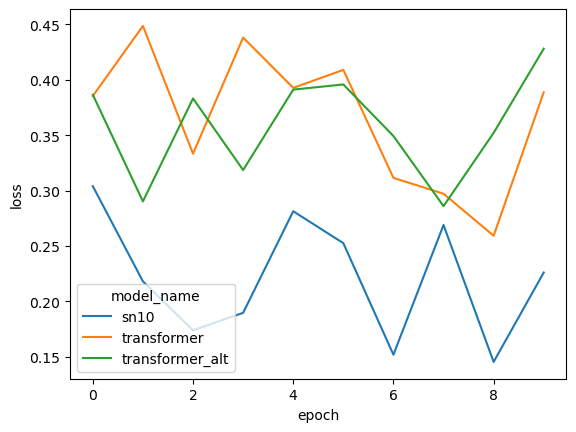

In [51]:
sns.lineplot(data=df_res, x="epoch", y="loss", hue="model_name")
# sns.lineplot(data=df_res, x="epoch", y="test_loss", hue="model_name")
# sns.lineplot(data=df_res, x="epoch", y="acc_closed", hue="model_name")

In [47]:
# df_res.groupby("model_name").agg({"loss": "min"})
df_res.groupby("model_name").agg({"acc_closed": "min"})

,acc_closed
model_name,
sn10,0.8715
transformer,0.8385
transformer_alt,0.8395


## Evaluate in complex multiclass setup

In [48]:
# TODO